### Code Summary

This code imports essential libraries for data manipulation (pandas, numpy), model building (TensorFlow, Keras), data preprocessing (LabelEncoder, StandardScaler), and utility functions (train_test_split, matplotlib). It prepares the environment for building and training a gesture recognition model using data augmentation, model saving/loading, and visualization of results.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
import tensorflow as tf
from tensorflow.keras import layers, models
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
from datetime import datetime
import joblib

### Code Summary

- Reads a CSV file (`combined_dataset.csv`) into a DataFrame `df`.
- There is a commented-out section for reading another CSV (`hand_landmarks_from_4500_to_5000.csv`) and concatenating it with `df1` to form a combined DataFrame `df`.


In [2]:
df = pd.read_csv('new_landmarks/combined_dataset.csv')
# df2 = pd.read_csv('hand_landmarks_from_4500_to_5000.csv')

# df = pd.concat([df1, df2], ignore_index=True)
# df

### Code Summary

- Filters the DataFrame `df` to exclude rows where the 'class' column is equal to `'to'`.
- Displays the last few rows of the filtered DataFrame using `df.tail()`.


In [3]:
df = df[df['class'] != 'to']
df.tail()

,class,landmarks
2455,z,"[[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0],..."
2456,z,"[[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0],..."
2457,z,"[[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0],..."
2458,z,"[[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0],..."
2459,z,"[[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0],..."


### Code Summary

- **Function**: `preprocess_data(df)` 
  - Converts landmarks to numeric format.
  - Encodes class labels using `LabelEncoder`.
  - Returns processed DataFrame and encoder.

- **Result**: The `df` is updated with numeric landmarks and class labels encoded as `encoded_class`.


In [4]:
def preprocess_data(df, landmarks_column="landmarks", class_column="class"):
    """
    Preprocess the dataset for model training.

    Args:
        df (pd.DataFrame): DataFrame with class labels and landmarks columns.
        landmarks_column (str): Name of the column containing landmarks.
        class_column (str): Name of the column containing class labels.

    Returns:
        pd.DataFrame: Processed DataFrame with numeric landmarks and encoded labels.
        LabelEncoder: Encoder for decoding class labels.
    """
    # Ensure landmarks are in numeric format
    df[landmarks_column] = df[landmarks_column].apply(
        lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else np.array(x)
    )

    # Encode class labels
    le = LabelEncoder()
    df["encoded_class"] = le.fit_transform(df[class_column])

    return df, le

# Apply the preprocessing
df, label_encoder = preprocess_data(df)


### Code Summary

- **Purpose**: Prints the number of unique classes after label encoding.
  - `num_classes`: Total number of unique classes.
  - Prints the class labels and their count.


In [5]:
num_classes = len(label_encoder.classes_)
print(label_encoder.classes_, num_classes)

['a' 'about' 'aim' 'all' 'and' 'audio' 'b' 'barrier' 'break' 'c' 'can'
 'communication' 'creative' 'd' 'detect' 'developed' 'e' 'f' 'g' 'h'
 'have' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'our' 'p' 'project' 'q' 'r' 's'
 'sign language' 'solution' 't' 'team' 'text' 'that' 'translate' 'u' 'v'
 'w' 'what' 'x' 'y' 'you' 'z'] 49


### Code Summary

- **Purpose**: Applies random noise and scaling to augment landmark data.
- **Input**:
  - `landmarks`: The original landmark data as a NumPy array.
  - `max_noise`: Maximum noise added (default = 0.01).
  - `scale_range`: Range for random scaling (default = `(0.9, 1.1)`).
- **Process**:
  - Converts landmarks to `float64`.
  - Adds random noise and applies scaling.
- **Output**: Returns the augmented landmarks as a NumPy array.


In [6]:
def augment_landmarks(landmarks, max_noise=0.01, scale_range=(0.9, 1.1)):
    """
    Apply random augmentations to landmarks.

    Args:
        landmarks (np.ndarray): Original landmarks array.
        max_noise (float): Maximum noise to add to each coordinate.
        scale_range (tuple): Range for random scaling factors.

    Returns:
        np.ndarray: Augmented landmarks.
    """
    # Ensure landmarks are float64 for operations
    landmarks = landmarks.astype(np.float64)
    
    # Add random noise
    noise = np.random.uniform(-max_noise, max_noise, size=landmarks.shape)
    landmarks += noise

    # Apply random scaling
    scale_factor = random.uniform(*scale_range)
    landmarks *= scale_factor

    return landmarks

### Code Summary

- **Purpose**: Augments the dataset by creating multiple augmented versions of the landmark data.
- **Input**:
  - `df`: DataFrame containing 'class' and 'landmarks' columns.
  - `num_augmentations`: Number of augmented rows per original row (default = 5).
- **Process**:
  - For each row, creates augmented landmarks using `augment_landmarks`.
  - Combines original and augmented rows into a new DataFrame.
- **Output**: Returns a DataFrame with both original and augmented data.


In [7]:
def augment_dataset(df, num_augmentations=5):
    """
    Augment the dataset by creating multiple augmented landmarks data for each row.

    Args:
        df (pd.DataFrame): DataFrame with 'class' and 'landmarks' columns.
        num_augmentations (int): Number of augmented rows to create per original row.

    Returns:
        pd.DataFrame: DataFrame with augmented data added.
    """
    augmented_rows = []
    
    for _, row in df.iterrows():
        original_landmarks = np.array(row["landmarks"])
        
        # Generate multiple augmentations for each row
        for _ in range(num_augmentations):
            augmented_landmarks = augment_landmarks(original_landmarks)
            
            # Create a new row with the same class and augmented landmarks
            new_row = {
                "class": row["class"],
                "landmarks": augmented_landmarks.tolist(),  # Convert to list for DataFrame compatibility
                "encoded_class": row.get("encoded_class", None)  # Handle missing 'encoded_class'
            }
            augmented_rows.append(new_row)
    
    # Convert augmented rows to DataFrame
    augmented_df = pd.DataFrame(augmented_rows)
    
    # Combine original and augmented data
    combined_df = pd.concat([df, augmented_df], ignore_index=True)
    return combined_df

### Code Summary

The line of code performs the following tasks:

1. **Function Call**: 
   - The `augment_dataset` function is called with `df` (original dataset) as the input.
   - It generates 3 augmented versions for each row of the original dataset (`num_augmentations=3`).

2. **Output**:
   - The augmented data is stored in the variable `df_org_augmented`, which contains both the original and augmented rows.

   **Purpose**: This is used to increase the dataset size and diversity through data augmentation, aiding in better model generalization.


In [8]:
df_org_augmented = augment_dataset(df, num_augmentations=3)

### Code Summary

This block of code defines the following parameters:

1. **timesteps**: 
   - Represents the number of time steps (50).
   - Used for sequential data, like gestures or time-series data.

2. **frames**: 
   - Number of frames per time step (21).
   - Typically used to represent different landmarks or points in each time step.

3. **features**: 
   - The number of features per frame (3).
   - Each frame consists of 3 features, possibly representing coordinates or other metrics for the landmarks.

These parameters are essential for organizing the input data structure when preparing the dataset for machine learning or neural network models, especially when dealing with sequential data or video-like frames.


In [9]:
# Define timesteps, frames, and features
timesteps = 50  # Time steps
frames = 21  # Number of frames per time step
features = 3  # Number of features per frame

### Code Summary

This line of code splits the augmented dataset `df_org_augmented` into two sets:

1. **df_train**: 
   - The training dataset, containing 80% of the original data (since `test_size=0.2`).

2. **df_val**: 
   - The validation dataset, containing 20% of the original data, used to evaluate the model performance during training.

- `train_test_split` is used to randomly split the data.
- `random_state=42` ensures reproducibility of the split.


In [10]:
# Split the dataset into training and validation sets
df_train, df_val = train_test_split(df_org_augmented, test_size=0.2, random_state=42)

### Code Summary

This code prepares the input features (`X_train`, `X_val`) and the labels (`y_train`, `y_val`) for training and validation:

1. **`X_train` and `X_val`**: 
   - The landmarks are reshaped into a 3D format of shape `(timesteps, frames, features)`, where:
     - `timesteps = 50`
     - `frames = 21`
     - `features = 6` (since each frame has 21 landmarks, each with 3 features).
   
2. **`y_train` and `y_val`**: 
   - The labels are taken from the `encoded_class` column and stored as arrays for both training and validation.

Finally, the shape and size of the resulting datasets (`X_train`, `y_train`, `X_val`, `y_val`) are printed to verify the data preparation.


In [11]:
# Prepare X_train and y_train from the training set
X_train = np.array([
    np.array(landmark).reshape(50, 21, 6) 
    for landmark in df_train["landmarks"]
])
y_train = df_train["encoded_class"].values

# Prepare X_val and y_val from the validation set
X_val = np.array([
    np.array(landmark).reshape(50, 21, 6) 
    for landmark in df_val["landmarks"]
])
y_val = df_val["encoded_class"].values

# Verify the split and shapes
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

Training set size: 7712
Validation set size: 1928
X_train shape: (7712, 50, 21, 6)
y_train shape: (7712,)
X_val shape: (1928, 50, 21, 6)
y_val shape: (1928,)


### Code Summary

This code performs the following steps to preprocess the data for model training:

1. **Flatten the Data**:
   - `X_train` and `X_val` are reshaped from 3D (timesteps, frames, features) to 2D by flattening the landmarks into a single vector per sample (samples, timesteps * features).
   
2. **Normalization**:
   - A `StandardScaler` is applied to normalize the flattened data. The scaler is fit on the training data (`X_train_flattened`) and then used to transform both the training and validation data.
   
3. **Reshape Back to 3D**:
   - The normalized data is reshaped back to the original 3D format (samples, timesteps, frames, features) for model compatibility.

This preprocessing ensures that the data is scaled and structured correctly for model training while maintaining the original dimensions required for the model's input.


In [12]:
# Flatten the data to 2D (samples, timesteps * features)
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_val_flattened = X_val.reshape(X_val.shape[0], -1)

# Normalize landmarks (fit_transform on the training set, and transform on validation)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_val_scaled = scaler.transform(X_val_flattened)

# Reshape the scaled data back to the original 3D shape (50, 21, 6)
X_train = X_train_scaled.reshape(X_train.shape[0], 50, 21, 6)
X_val = X_val_scaled.reshape(X_val.shape[0], 50, 21, 6)

### Code Summary

This code prints the shapes of the reshaped `X_train` and `X_val` datasets to verify that the reshaping and normalization processes were successful. The printed shapes provide information about the dimensions of the data after it has been flattened, normalized, and then reshaped back into its original 3D form (timesteps, frames, features).


In [13]:
# Check the shapes after reshaping
print(f"X_train shape after reshaping: {X_train.shape}")
print(f"X_val shape after reshaping: {X_val.shape}")

X_train shape after reshaping: (7712, 50, 21, 6)
X_val shape after reshaping: (1928, 50, 21, 6)


### Code Summary

This code converts the class labels `y_train` and `y_val` into one-hot encoded labels using Keras' `to_categorical` function. One-hot encoding transforms the class labels into a binary matrix where each label is represented as a vector of zeros with a one at the index corresponding to the class.


In [14]:
# Convert labels to one-hot encoding
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train, num_classes)
y_val_one_hot = to_categorical(y_val, num_classes)

### Code Summary

The code defines the parameters for the Vision Transformer (ViT) model input:

- **Timesteps**: Set to 50, representing the number of time steps (or frames) in each sample.
- **Features**: Set to 126 (21 landmarks * 6 values per landmark), representing the number of features per frame.

These parameters determine the input shape for the ViT model, where each frame has 126 features across 50 time steps.


In [15]:
# Flatten the 3D input for ViT model (timesteps, features)
timesteps = 50  # Number of timesteps (frames)
features = 21 * 6  # Features per frame (21 landmarks * 6 values)

### Code Summary

The code reshapes the training and validation data to fit the input format required by the Vision Transformer (ViT) model:

- **X_train_vit**: Reshapes the training data (`X_train`) to a 3D array with dimensions `(-1, timesteps, features)` (samples, 50 time steps, 126 features per time step).
- **X_val_vit**: Reshapes the validation data (`X_val`) similarly.

This prepares the data for use with the ViT model, where each sample is structured as a sequence of frames (timesteps) with corresponding features.


In [16]:
X_train_vit = X_train.reshape(-1, timesteps, features)
X_val_vit = X_val.reshape(-1, timesteps, features)

### Code Summary

This code defines a gesture classification model using BlazePose-based features and LSTM (Long Short-Term Memory) layers to capture temporal dependencies in the data:

- **Input Layer**: Accepts input of shape `(timesteps, features)` where `timesteps` represent the number of frames, and `features` represent the features per frame (e.g., 21 landmarks with x, y, z coordinates).
- **Layer Normalization**: Normalizes the input features to improve training stability.
- **LSTM Layer**: Captures the temporal relationships in the sequence of frames.
- **Fully Connected Layers**: Two dense layers with ReLU activation and dropout are used for classification.
- **Output Layer**: A softmax layer with `num_classes` output units, providing the class predictions.

The model is compiled with the Adam optimizer and categorical crossentropy loss function, suitable for multi-class classification.

The model summary is displayed after it is built.


In [20]:
from mediapipe.python.solutions.hands import Hands

def build_blazepose_model(input_shape, num_classes):
    """
    Build a model for gesture classification using BlazePose-based features.

    Args:
        input_shape (tuple): Shape of the input (timesteps, features).
        num_classes (int): Number of gesture classes.

    Returns:
        keras.Model: Compiled model.
    """
    input_layer = layers.Input(shape=input_shape)

    # Process BlazePose landmark features
    x = layers.LayerNormalization()(input_layer)

    # Add LSTM to capture temporal dependencies
    x = layers.LSTM(256, return_sequences=False)(x)
    x = layers.Dropout(0.5)(x)

    # Fully connected layers for classification
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

# Define input shape and number of classes
timesteps = 50  # Example value, replace with actual
features = 21 * 3 * 2  # Example: 21 landmarks with x, y, z coordinates

input_shape = (timesteps, features)
model = build_blazepose_model(input_shape, num_classes)

# Display model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 50, 126)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 50, 126)             │             252 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         392,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 49)                  │           6,321 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 431,661 (1.65 MB)

 Trainable params: 431,661 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

### Code Summary

This code sets up a TensorBoard callback for monitoring the model's training process:

- **Log Directory**: The `log_dir` is dynamically generated using the current date and time (`datetime.now().strftime("%Y%m%d-%H%M%S")`) and stored in a folder named `logs/fit/`.
- **TensorBoard Callback**: The `TensorBoard` callback is initialized with the `log_dir` to log metrics like loss and accuracy during training. The `histogram_freq=1` argument enables logging of histograms for model weights.

This callback can be used to visualize training metrics in TensorBoard during or after training.



In [21]:
# Set up the log directory for TensorBoard
log_dir = os.path.join("logs", "fit", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### Code Summary

This code trains the model on the reshaped input data `X_train_vit` and one-hot encoded labels `y_train_one_hot`, while validating on `X_val_vit` and `y_val_one_hot`. 

- **Parameters**:
  - `epochs=50`: The model will be trained for 50 epochs.
  - `batch_size=8`: The training data will be split into batches of 8.
  - `callbacks`: 
    - **EarlyStopping**: Stops training if the validation loss does not improve for 5 consecutive epochs (`patience=5`). The best model weights are restored when training stops.
    - **TensorBoard**: Logs the training process to visualize metrics like loss and accuracy.

- **Verbose**: The training progress will be displayed during each epoch (`verbose=1`).

This code enables efficient training with early stopping and the ability to track the training process using TensorBoard.


In [22]:
# Train the model
history = model.fit(
    X_train_vit,  # Reshaped training data
    y_train_one_hot,  # One-hot encoded labels for training
    validation_data=(X_val_vit, y_val_one_hot),  # Reshaped validation data and labels
    epochs=50,  # Number of epochs
    batch_size=8,  # Mini-batch size
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',  # Monitor validation loss
            patience=5,  # Stop training if no improvement for 5 epochs
            restore_best_weights=True  # Restore the best model weights
        ),
        tensorboard_callback  # TensorBoard callback
    ],
    verbose=1  # Display training progress
)

Epoch 1/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 50s 48ms/step - accuracy: 0.1373 - loss: 3.4510 - val_accuracy: 0.7308 - val_loss: 1.5988
Epoch 2/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 51s 53ms/step - accuracy: 0.5949 - loss: 1.7003 - val_accuracy: 0.8755 - val_loss: 0.6122
Epoch 3/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 47s 49ms/step - accuracy: 0.7632 - loss: 0.9539 - val_accuracy: 0.9450 - val_loss: 0.2820
Epoch 4/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 50s 52ms/step - accuracy: 0.8675 - loss: 0.5664 - val_accuracy: 0.9761 - val_loss: 0.1274
Epoch 5/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 47s 48ms/step - accuracy: 0.9190 - loss: 0.3572 - val_accuracy: 0.9808 - val_loss: 0.0885
Epoch 6/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 48s 50ms/step - accuracy: 0.9410 - loss: 0.2623 - val_accuracy: 0.9850 - val_loss: 0.0634
Epoch 7/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 49s 51ms/step - accuracy: 0.9612 - loss: 0.1708 - val_accuracy: 0.9901 - val_loss: 0.0364
Epoch 8/50
964/964 ━━━━━━━━━━━━━━━━━━━━ 50s 51ms/step - accuracy: 0.9694 - loss: 0.1480 - 

### Code Summary

This code visualizes the training and validation performance of the model by plotting the loss and accuracy over the epochs:

1. **Training and Validation Loss Plot**:
   - `plt.plot(history.history['loss'])`: Plots the training loss across epochs.
   - `plt.plot(history.history['val_loss'])`: Plots the validation loss across epochs.
   - `plt.legend()`: Displays a legend to distinguish between training and validation losses.
   - The graph helps to assess the model's learning progress and check if it is overfitting (i.e., validation loss increasing while training loss decreases).

2. **Training and Validation Accuracy Plot**:
   - `plt.plot(history.history['accuracy'])`: Plots the training accuracy across epochs.
   - `plt.plot(history.history['val_accuracy'])`: Plots the validation accuracy across epochs.
   - This plot helps to visualize how well the model is generalizing to new, unseen data during training.

By visualizing these metrics, you can identify overfitting, underfitting, or if the model is performing well during training.


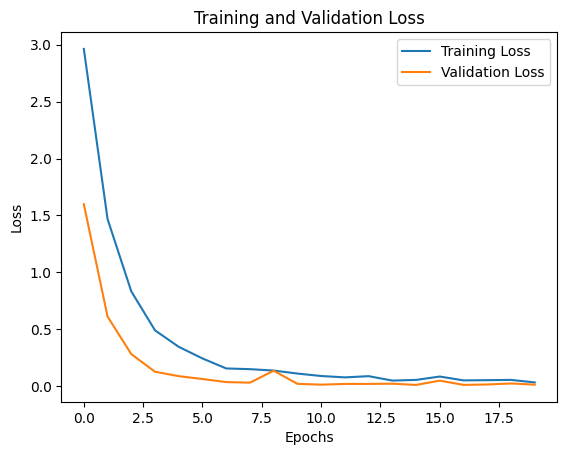

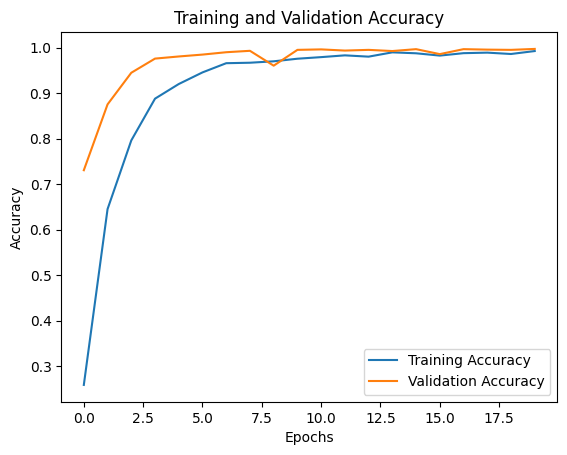

In [23]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()


### Code Summary

This code saves the `scaler` object (which is used to normalize the dataset) to a file using `joblib`:

1. **Saving the Scaler**:
   - `scaler_save_path = "scaler.pkl"`: Defines the path where the scaler will be saved (as a `.pkl` file).
   - `joblib.dump(scaler, scaler_save_path)`: Saves the scaler object to the specified path.
   - `print(f"Scaler saved to: {scaler_save_path}")`: Prints a confirmation message to indicate that the scaler has been successfully saved.

The scaler is typically saved so that it can be reused for future data transformations or for inference without needing to retrain the scaling parameters.


In [24]:

# Assuming 'scaler' is your scaler object
scaler_save_path = "scaler.pkl"
joblib.dump(scaler, scaler_save_path)
print(f"Scaler saved to: {scaler_save_path}")


Scaler saved to: scaler.pkl


### Code Summary

This code saves the trained model to a file:

1. **Define Model Save Path**:
   - `model_save_path = "my_vit_model.h5"`: Specifies the path where the model will be saved (as a `.h5` file).
   
2. **Save the Model**:
   - `model.save(model_save_path)`: Saves the entire model (architecture, weights, and optimizer state) to the specified file path.

3. **Confirmation Message**:
   - `print(f"Model saved to: {model_save_path}")`: Prints a confirmation message indicating that the model has been successfully saved.

This process ensures that the trained model can be loaded again for inference or further training without needing to retrain it.


In [25]:
model_save_path = "my_vit_model.h5"
# Save the entire model
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: my_vit_model.h5


### Code Summary

This code demonstrates how to load and verify the saved model:

1. **Load the Saved Model**:
   - `loaded_model = tf.keras.models.load_model(model_save_path)`: Loads the model from the specified file path (`model_save_path`). The model contains both the architecture and trained weights.

2. **Verify the Model Structure**:
   - `loaded_model.summary()`: Displays a summary of the loaded model, including the layers, their output shapes, and the number of parameters in the model.

This code allows you to verify that the saved model was correctly loaded and retains its original structure after being saved.


In [26]:
# Load the saved model
loaded_model = tf.keras.models.load_model(model_save_path)

# Verify the model structure
loaded_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 50, 126)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 50, 126)             │             252 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         392,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 49)                  │           6,321 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 431,663 (1.65 MB)

 Trainable params: 431,661 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)